In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Attention, Input

In [4]:
# Loading
url = 'https://raw.githubusercontent.com/shoukewei/data/main/data-wpt/USD_CNY%20Historical%20Data.csv'
df = pd.read_csv(url)

# Convergence and reset
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2012-09-24,6.3093,6.3048,6.3099,6.2988,NaN,0.06%
1,2012-09-25,6.3062,6.3093,6.3115,6.3019,NaN,-0.05%
2,2012-09-26,6.3020,6.3063,6.3085,6.3010,NaN,-0.07%
3,2012-09-27,6.3023,6.3019,6.3084,6.3007,NaN,0.00%
4,2012-09-28,6.2845,6.3025,6.3025,6.2837,NaN,-0.28%
...,...,...,...,...,...,...,...
2588,2022-09-19,7.0050,6.9957,7.0206,6.9956,NaN,0.36%
2589,2022-09-20,7.0176,7.0100,7.0214,7.0044,NaN,0.18%
2590,2022-09-21,7.0479,7.0183,7.0546,7.0183,NaN,0.43%
2591,2022-09-22,7.0781,7.0490,7.0956,7.0488,NaN,0.43%


In [5]:
#preposaaass
data = df['Price'].values.reshape(-1, 1)

# Normalizz
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
#Le splitt
train_size = int(0.8 * len(scaled_data))
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [18]:
#le load
base = load_model("tizi.h5")

In [20]:
# Print the input and output shapes
input_shape = base.input_shape
output_shape = base.output_shape

input_length = input_shape[1]
output_length = output_shape[1]

print("Input Length:", input_length)
print("Output Length:", output_length)

Input Length: 5
Output Length: 3


In [21]:
base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 100)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 100)            80400     
                                                                 
 time_distributed (TimeDist  (None, 3, 1)              101       
 ributed)                                                        
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Creaton in'n'out sex
input_length = 5
output_length = 3

def create_sequences(data, input_length, output_length):
    X = []
    y = []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length])
        y.append(data[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)

train_X, train_y = create_sequences(train_data, input_length, output_length)
test_X, test_y = create_sequences(test_data, input_length, output_length)

In [27]:
# Freezer
#for layer in base.layers:
 #   layer.trainable = False
#or
base.trainable = False

In [29]:
# Creaton model 2.0 while excluding batch size dimenstion
new_model_input = Input(shape=base.input_shape[1:]) 
output = base(new_model_input)

# Add atähnchen layär
output = Attention()([output, output])

# more onions!!
output = Dense(128, activation='relu')(output)
output = Dense(1, activation='relu')(output)

new_model = Model(inputs=new_model_input, outputs=output)

# Disblay new
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 sequential (Sequential)     (None, 3, 1)                 121301    ['input_2[0][0]']             
                                                                                                  
 attention_1 (Attention)     (None, 3, 1)                 0         ['sequential[1][0]',          
                                                                     'sequential[1][0]']          
                                                                                                  
 dense_2 (Dense)             (None, 3, 128)               256       ['attention_1[0][0]']   

In [30]:
# cumpile
new_model.compile(optimizer='adam', loss='mean_squared_error')

In [57]:
#train like Goku
initial_epochs = 50
history = new_model.fit(train_X, train_y, epochs=initial_epochs, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/50
65/65 [==============================] - 1s 9ms/step - loss: 3.5249e-04 - val_loss: 4.8335e-04
Epoch 2/50
65/65 [==============================] - 1s 8ms/step - loss: 3.4780e-04 - val_loss: 5.6134e-04
Epoch 3/50
65/65 [==============================] - 1s 8ms/step - loss: 3.3306e-04 - val_loss: 4.8708e-04
Epoch 4/50
65/65 [==============================] - 0s 7ms/step - loss: 3.3472e-04 - val_loss: 5.0109e-04
Epoch 5/50
65/65 [==============================] - 1s 9ms/step - loss: 3.4319e-04 - val_loss: 5.0034e-04
Epoch 6/50
65/65 [==============================] - 1s 9ms/step - loss: 3.1623e-04 - val_loss: 4.8139e-04
Epoch 7/50
65/65 [==============================] - 1s 8ms/step - loss: 3.2603e-04 - val_loss: 5.2163e-04
Epoch 8/50
65/65 [==============================] - 1s 8ms/step - loss: 3.3436e-04 - val_loss: 4.9171e-04
Epoch 9/50
65/65 [==============================] - 0s 8ms/step - loss: 3.4176e-04 - val_loss: 5.0135e-04
Epoch 10/50
65/65 [===========================

In [58]:
# Eval b4 test
loss0 = new_model.evaluate(test_X, test_y)
print("initial loss::", loss0)

16/16 [==============================] - 0s 4ms/step - loss: 4.6167e-04
initial loss:: 0.00046166570973582566


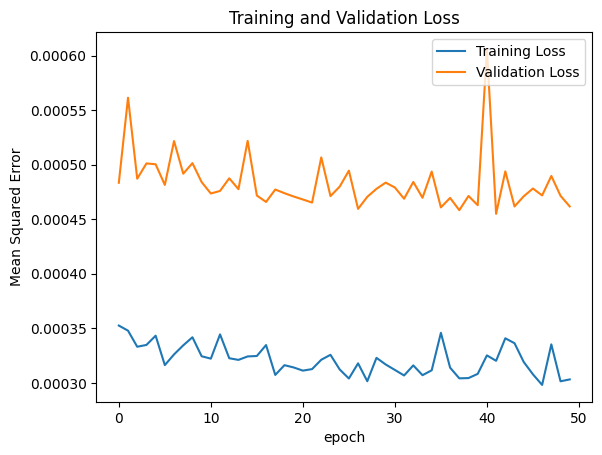

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [60]:
base.trainable = True

In [61]:
print("Number of layers in the base model: ", len(base.layers))

Number of layers in the base model:  4


In [62]:
#fine tuning
fine_tune_at = 2

#freeze onion for fine dine tune
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False


In [63]:
#microwave last onions for fine dine
unfreeze_layers = 3
for layer in base.layers[-unfreeze_layers:]:
    layer.trainable = True

In [64]:
#compile'n'display

new_model.compile(optimizer ='adam', loss = 'mean_squared_error')
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 sequential (Sequential)     (None, 3, 1)                 121301    ['input_2[0][0]']             
                                                                                                  
 attention_1 (Attention)     (None, 3, 1)                 0         ['sequential[1][0]',          
                                                                     'sequential[1][0]']          
                                                                                                  
 dense_2 (Dense)             (None, 3, 128)               256       ['attention_1[0][0]']   

In [65]:
len(new_model.trainable_variables)

9

In [66]:
#train like fine Goku
fine_tune_ep = 50
total_eps = initial_epochs + fine_tune_ep

history_ft = new_model.fit(train_X, train_y, epochs=total_eps, initial_epoch=history.epoch[-1], batch_size=32, validation_data=(test_X, test_y))

Epoch 50/100
65/65 [==============================] - 4s 16ms/step - loss: 3.1479e-04 - val_loss: 4.7578e-04
Epoch 51/100
65/65 [==============================] - 1s 8ms/step - loss: 3.0890e-04 - val_loss: 4.6047e-04
Epoch 52/100
65/65 [==============================] - 1s 10ms/step - loss: 3.2771e-04 - val_loss: 4.5889e-04
Epoch 53/100
65/65 [==============================] - 1s 9ms/step - loss: 3.0899e-04 - val_loss: 4.8079e-04
Epoch 54/100
65/65 [==============================] - 1s 9ms/step - loss: 3.1759e-04 - val_loss: 5.7134e-04
Epoch 55/100
65/65 [==============================] - 1s 8ms/step - loss: 3.2262e-04 - val_loss: 4.8344e-04
Epoch 56/100
65/65 [==============================] - 1s 8ms/step - loss: 3.0130e-04 - val_loss: 4.6452e-04
Epoch 57/100
65/65 [==============================] - 1s 8ms/step - loss: 3.0825e-04 - val_loss: 4.6583e-04
Epoch 58/100
65/65 [==============================] - 1s 8ms/step - loss: 3.2433e-04 - val_loss: 4.5876e-04
Epoch 59/100
65/65 [======

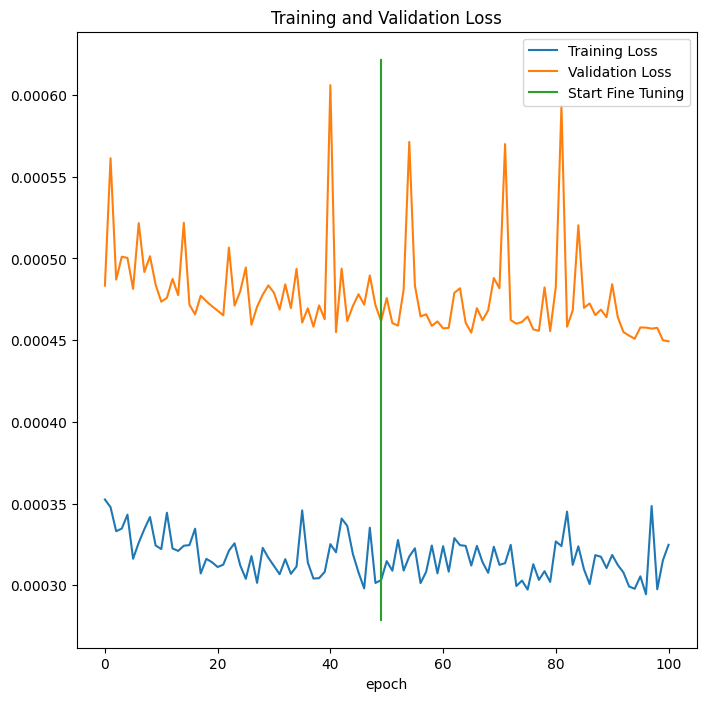

In [67]:
# visualize the loss curve of the training and validation
loss += history_ft.history['loss']
val_loss += history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [68]:
loss = new_model.evaluate(test_X, test_y)
print("loss::", loss)

16/16 [==============================] - 0s 5ms/step - loss: 4.4929e-04
loss:: 0.0004492936423048377


16/16 [==============================] - 0s 5ms/step


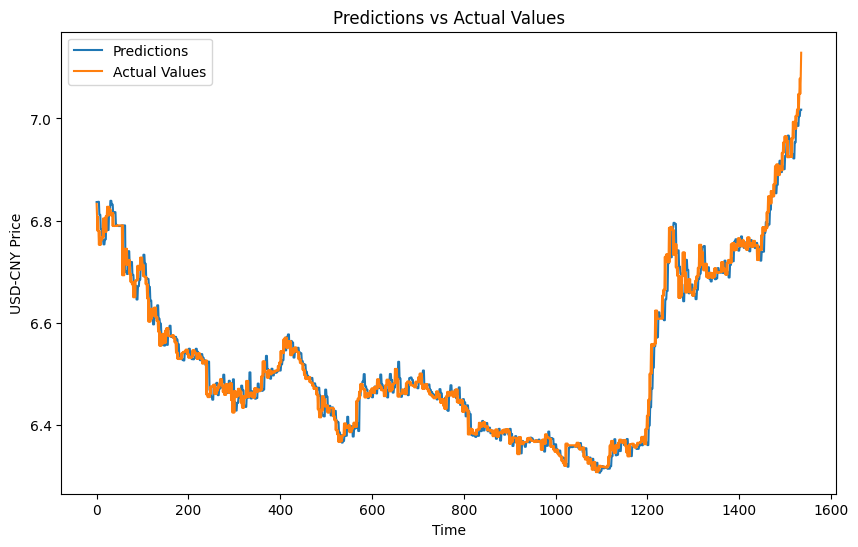

In [70]:
# Get predictions for the test set
predictions = new_model.predict(test_X)

# Reshape the predictions array
predictions = predictions.reshape(-1, output_length)

# Rescale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(test_y.reshape(-1, output_length))

# Flatten the arrays for plotting
predictions = predictions.flatten()
actual_values = actual_values.flatten()

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predictions')
plt.plot(actual_values, label='Actual Values')
plt.xlabel('Time')
plt.ylabel('USD-CNY Price')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()